In [1]:
pip install catboost matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 17.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.9/415.9 kB 7.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 1.9 MB/s eta 0:00:00a 0:00:01


# **Đọc dữ liệu**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, monotonically_increasing_id
import os

# Thiết lập SparkSession
spark = SparkSession.builder \
    .appName("SkylineQueryWithCatBoostAndDelta") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "8") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

# Đọc dataset
data_path = "flights_sampled_1M.csv"
df_full = spark.read.csv(data_path, header=True, inferSchema=True).repartition(200).cache()

# Thêm cột ID nếu chưa có
if "ID" not in df_full.columns:
    df_full = df_full.withColumn("ID", monotonically_increasing_id())

# Tạo cột TAXI_TOTAL
df_full = df_full.withColumn("TAXI_TOTAL", col("TAXI_OUT") + col("TAXI_IN"))

# Lấy các tập con 100k, 300k, 500k dòng đầu tiên
df_100 = df_full.limit(100000)
df_300 = df_full.limit(300000)
df_500 = df_full.limit(500000)

# Tạo thư mục output nếu chưa tồn tại
out_base = "/home/jovyan/output/original"
os.makedirs(out_base, exist_ok=True)

# Xóa file cũ trước khi lưu
for size in [100, 300, 500]:
    out_path = f"{out_base}/data_{size}.parquet"
    if os.path.exists(out_path):
        os.system(f"rm -rf {out_path}")

# Lưu các file Parquet
df_100.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/data_100.parquet")
df_300.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/data_300.parquet")
df_500.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/data_500.parquet")

# === CÁC CỘT CẦN HIỂN THỊ ===
cols_show = ["ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
             "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"]

# In thông tin
print(">>> File data_100.parquet đã lưu (100k dòng đầu tiên)")
print("Số dòng:", df_100.count())
df_100.select(cols_show).show(5, truncate=False)

print(">>> File data_300.parquet đã lưu (300k dòng đầu tiên)")
print("Số dòng:", df_300.count())
df_300.select(cols_show).show(5, truncate=False)

print(">>> File data_500.parquet đã lưu (500k dòng đầu tiên)")
print("Số dòng:", df_500.count())
df_500.select(cols_show).show(5, truncate=False)

# Hiển thị schema và 5 dòng đầu tiên của df_full
df_full.printSchema()
df_full.select(cols_show).show(5)

# Kiểm tra thống kê dữ liệu
df_full.select(cols_show).describe().show()


>>> File data_100.parquet đã lưu (100k dòng đầu tiên)
Số dòng: 100000
+-------------+----------+------------+---------------+--------+--------+-------+
|ARRIVAL_DELAY|TAXI_TOTAL|ELAPSED_TIME|DEPARTURE_DELAY|DISTANCE|TAXI_OUT|TAXI_IN|
+-------------+----------+------------+---------------+--------+--------+-------+
|-5.0         |16.0      |86.0        |-1.0           |480     |14.0    |2.0    |
|20.0         |48.0      |217.0       |3.0            |1107    |43.0    |5.0    |
|-12.0        |29.0      |185.0       |3.0            |1381    |13.0    |16.0   |
|-9.0         |21.0      |131.0       |-1.0           |731     |10.0    |11.0   |
|-10.0        |22.0      |111.0       |-5.0           |645     |8.0     |14.0   |
+-------------+----------+------------+---------------+--------+--------+-------+
only showing top 5 rows

>>> File data_300.parquet đã lưu (300k dòng đầu tiên)
Số dòng: 300000
+-------------+----------+------------+---------------+--------+--------+-------+
|ARRIVAL_DELAY|

# **Skyline BBS cho dữ liệu đầy đủ**

In [6]:
# === BBS Skyline trên nhiều dataset + Lưu kết quả ===
from pyspark.sql import functions as F
from functools import reduce
from time import time
import os

# ==== Cấu hình ====
criteria_7d = ["ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
               "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"]
sizes = [100000, 300000, 500000]

base = "/home/jovyan/output/original"
out_dir = os.path.join(base, "skyline_bbs_results")
os.makedirs(out_dir, exist_ok=True)

# Xóa file skyline cũ nếu tồn tại
for size in sizes:
    out_path = os.path.join(out_dir, f"skyline_bbs_{size//1000}k.parquet")
    if os.path.exists(out_path):
        os.system(f"rm -rf {out_path}")

# Chuẩn bị dict lưu kết quả
skyline_results = {"bbs": {}}
execution_times = {"bbs": {}}

# ==== Hàm kiểm tra chi phối ====
def dominates(row1, row2, criteria):
    """Kiểm tra xem row1 có chi phối row2 không"""
    better_in_at_least_one = False
    for crit in criteria:
        if row1[crit] is None or row2[crit] is None:
            return False
        if row1[crit] > row2[crit]:
            return False
        if row1[crit] < row2[crit]:
            better_in_at_least_one = True
    return better_in_at_least_one

# ==== Hàm BBS Skyline (RDD) ====
def skyline_bbs(df, criteria, num_partitions=200):
    start_time = time()
    rdd = df.select(["ID"] + criteria).rdd.repartition(num_partitions)

    def process_partition(iterator):
        local_skyline = []
        for row in iterator:
            is_skyline = not any(dominates(sky.asDict(), row.asDict(), criteria) 
                                 for sky in local_skyline)
            if is_skyline:
                local_skyline = [sky for sky in local_skyline 
                                 if not dominates(row.asDict(), sky.asDict(), criteria)]
                local_skyline.append(row)
        return local_skyline

    partition_skyline = rdd.mapPartitions(process_partition).collect()

    final_skyline = []
    for row in partition_skyline:
        is_skyline = not any(dominates(sky.asDict(), row.asDict(), criteria) 
                             for sky in final_skyline)
        if is_skyline:
            final_skyline = [sky for sky in final_skyline 
                             if not dominates(row.asDict(), sky.asDict(), criteria)]
            final_skyline.append(row)

    skyline_ids = [row["ID"] for row in final_skyline]
    elapsed = time() - start_time
    print(f"⏱️ Thời gian xử lý BBS Skyline: {elapsed:.2f} giây")
    skyline_df = spark.createDataFrame([(id,) for id in skyline_ids], ["ID"]).join(df, "ID")
    return skyline_df, elapsed

# ==== Chạy Skyline BBS cho từng kích thước dataset ====
for size in sizes:
    print(f"\n🚀 Đang xử lý Skyline BBS cho dữ liệu {size} dòng ...")

    df_sample = df_full.limit(size).cache()

    # Ép kiểu numeric để chắc chắn
    for c in criteria_7d:
        df_sample = df_sample.withColumn(c, F.col(c).cast("double"))

    df_sample = df_sample.persist()

    # Thực thi Skyline
    skyline_df, elapsed = skyline_bbs(df_sample, criteria_7d, num_partitions=200)
    sky_count = skyline_df.count()

    # Lưu kết quả vào dict
    skyline_results["bbs"][size] = {}
    skyline_results["bbs"][size][0.0] = skyline_df.cache()
    execution_times["bbs"][size] = {0.0: elapsed}

    # In kết quả
    print(f"[{size}] ⭐ Tổng số chuyến bay skyline: {sky_count}")
    skyline_df.select(["ID"] + criteria_7d).show(10, truncate=False)

    # Lưu ra file Parquet
    out_path = os.path.join(out_dir, f"skyline_bbs_{size//1000}k.parquet")
    skyline_df.write.mode("overwrite").parquet(out_path)
    print(f"[{size}] 💾 Đã lưu skyline vào: {out_path}")

    df_sample.unpersist()


🚀 Đang xử lý Skyline BBS cho dữ liệu 100000 dòng ...
⏱️ Thời gian xử lý BBS Skyline: 5.93 giây
[100000] ⭐ Tổng số chuyến bay skyline: 186
+------+-------------+----------+------------+---------------+--------+--------+-------+
|ID    |ARRIVAL_DELAY|TAXI_TOTAL|ELAPSED_TIME|DEPARTURE_DELAY|DISTANCE|TAXI_OUT|TAXI_IN|
+------+-------------+----------+------------+---------------+--------+--------+-------+
|923784|-45.0        |13.0      |191.0       |-5.0           |1389.0  |7.0     |6.0    |
|191432|-16.0        |10.0      |33.0        |-7.0           |106.0   |8.0     |2.0    |
|21232 |-25.0        |15.0      |49.0        |-9.0           |116.0   |4.0     |11.0   |
|275697|-35.0        |15.0      |40.0        |-20.0          |120.0   |7.0     |8.0    |
|296004|-55.0        |15.0      |180.0       |-9.0           |1532.0  |12.0    |3.0    |
|742895|-55.0        |17.0      |137.0       |-7.0           |1024.0  |9.0     |8.0    |
|638802|-38.0        |14.0      |103.0       |-7.0          

# **Bộ dữ liệu missing (10–30%) cho từng size (100k, 300k, 500k)**

In [8]:
from pyspark.sql.functions import col, rand, when, lit
import os

# ==== Cấu hình ====
output_base_path = "/home/jovyan/output/original"  # ĐÚNG với cell 1
missing_output_dir = os.path.join(output_base_path, "data_missing")  # Folder mới cho các file missing
os.makedirs(missing_output_dir, exist_ok=True)

sizes = [100000, 300000, 500000]
missing_rates = [0.1, 0.15, 0.2, 0.3]

# Các chiều Skyline
skyline_cols = [
    "ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
    "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"
]

# Xóa file missing cũ trước khi tạo mới
for size in sizes:
    for miss in missing_rates:
        filename = f"data_{size//1000}k_miss{int(miss*100)}.parquet"
        full_path = os.path.join(missing_output_dir, filename)
        if os.path.exists(full_path):
            os.system(f"rm -rf {full_path}")

# ==== Hàm tạo dữ liệu thiếu MCAR ====
def apply_mcar_missing(df, cols, missing_rate):
    for col_name in cols:
        df = df.withColumn(
            col_name,
            when(rand() < missing_rate, lit(None)).otherwise(col(col_name))
        )
    return df

# ==== Sinh dữ liệu ====
for size in sizes:
    # Đọc lại file gốc
    base_file = os.path.join(output_base_path, f"data_{size//1000}.parquet")
    print(f"\n➡ Đang xử lý {base_file} ...")
    df_base = spark.read.parquet(base_file)

    for miss in missing_rates:
        print(f"   🔧 Tạo missing {int(miss*100)}% ...")
        df_missing = apply_mcar_missing(df_base, skyline_cols, miss)

        # Lưu vào folder data_missing
        filename = f"data_{size//1000}k_miss{int(miss*100)}.parquet"
        full_path = os.path.join(missing_output_dir, filename)

        df_missing.write.mode("overwrite").parquet(full_path)
        print(f"   ✅ Đã lưu: {full_path} (missing {int(miss*100)}%)")

        # Hiển thị 10 dòng đầu 
        print(f"   👀 Preview 10 dòng đầu (missing {int(miss*100)}%):")
        df_missing.select(
            "ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
            "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"
        ).show(10, truncate=False)



➡ Đang xử lý /home/jovyan/output/original/data_100.parquet ...
   🔧 Tạo missing 10% ...
   ✅ Đã lưu: /home/jovyan/output/original/data_missing/data_100k_miss10.parquet (missing 10%)
   👀 Preview 10 dòng đầu (missing 10%):
+-------------+----------+------------+---------------+--------+--------+-------+
|ARRIVAL_DELAY|TAXI_TOTAL|ELAPSED_TIME|DEPARTURE_DELAY|DISTANCE|TAXI_OUT|TAXI_IN|
+-------------+----------+------------+---------------+--------+--------+-------+
|-5.0         |16.0      |86.0        |-1.0           |480     |14.0    |2.0    |
|20.0         |48.0      |217.0       |3.0            |1107    |43.0    |5.0    |
|-12.0        |NULL      |185.0       |3.0            |1381    |13.0    |16.0   |
|-9.0         |21.0      |131.0       |-1.0           |731     |10.0    |11.0   |
|-10.0        |22.0      |111.0       |-5.0           |645     |8.0     |14.0   |
|-4.0         |15.0      |162.0       |9.0            |918     |10.0    |NULL   |
|79.0         |127.0     |213.0       |

# **Điền giá trị thiếu bằng Catboost**

In [10]:
from catboost import CatBoostRegressor, Pool
import numpy as np
import pandas as pd
import os
import time
import shutil
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from sklearn.model_selection import train_test_split
import optuna
import logging

# Tắt log INFO của Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger("optuna").setLevel(logging.WARNING)

# Thư mục đầu vào & đầu ra
input_dir = "/home/jovyan/output/original/data_missing"
output_dir = "/home/jovyan/output/original/data_missing/data_imputed"
os.makedirs(output_dir, exist_ok=True)

# Cấu hình kích thước dataset và missing rate
sizes = [100000, 300000, 500000]
missing_rates = [0.1, 0.15, 0.2, 0.3]

# Hàm chọn chunk_size tự động
def auto_chunk_size(n_rows):
    if n_rows <= 100_000:
        return None
    elif n_rows <= 300_000:
        return 150_000
    elif n_rows <= 500_000:
        return 250_000

# Xóa file cũ
for size in sizes:
    for rate in missing_rates:
        rate_int = int(rate * 100)
        out_file = os.path.join(output_dir, f"data_{size//1000}k_miss{rate_int}_imputed.parquet")
        if os.path.exists(out_file):
            if os.path.isdir(out_file):
                shutil.rmtree(out_file)
            else:
                os.remove(out_file)
            print(f"🗑️ Đã xóa file/folder cũ: {out_file}")

# Hàm nội suy với CatBoost
def impute_missing_data(df_missing_spark, features, targets):
    df_imputed = df_missing_spark.cache()

    for target in targets:
        df_train = df_imputed.filter(col(target).isNotNull())
        df_predict = df_imputed.filter(col(target).isNull()).select(["ID"] + targets + features)
        if df_predict.count() == 0:
            continue

        train_pd = df_train.select(features + [target]).toPandas()
        predict_pd = df_predict.select(["ID"] + features + [target]).toPandas()

        # Giảm kích thước tập huấn luyện
        if len(train_pd) > 300_000:
            train_pd = train_pd.sample(frac=0.7, random_state=42).reset_index(drop=True)
        elif len(train_pd) > 100_000:
            train_pd = train_pd.sample(frac=0.9, random_state=42).reset_index(drop=True)

        # Feature engineering
        for df_pd in [train_pd, predict_pd]:
            df_pd['MONTH_DAY_INTER'] = df_pd['MONTH'] * df_pd['DAY_OF_WEEK']
            df_pd['LOG_DISTANCE'] = np.log1p(df_pd.get('DISTANCE', 0))
            df_pd['WEEKEND'] = (df_pd['DAY_OF_WEEK'] > 5).astype(int)
            df_pd['HOUR_BIN'] = pd.cut(
                df_pd['SCHEDULED_DEPARTURE'],
                bins=[0, 600, 900, 1500, 1800, 2400],
                labels=[0, 1, 2, 3, 4],
                include_lowest=True
            ).cat.codes
            df_pd['SCHEDULED_TIME_LOG'] = np.log1p(df_pd.get('SCHEDULED_TIME', 0))
            df_pd['IS_PEAK_HOUR'] = (df_pd['SCHEDULED_DEPARTURE'].between(600, 900) | 
                                     df_pd['SCHEDULED_DEPARTURE'].between(1500, 1800)).astype(int)
            df_pd['SEASON'] = np.select(
                [df_pd['MONTH'].isin([12,1,2]), df_pd['MONTH'].isin([3,4,5]),
                 df_pd['MONTH'].isin([6,7,8]), df_pd['MONTH'].isin([9,10,11])],
                [1,2,3,4], default=0
            )
            df_pd['SCHEDULED_ARRIVAL_HOUR'] = (df_pd['SCHEDULED_ARRIVAL'] // 100).astype(int)
            df_pd['FLIGHT_DURATION_CAT'] = pd.cut(
                df_pd['SCHEDULED_TIME'],
                bins=[0, 60, 180, float('inf')],
                labels=[0, 1, 2],
                include_lowest=True
            ).cat.codes
            elapsed = df_pd.get('ELAPSED_TIME', 1.0)
            if isinstance(elapsed, pd.Series):
                elapsed = elapsed.replace(0, 1e-6)
            df_pd['AIR_TIME_RATIO'] = df_pd.get('AIR_TIME', 1.0) / elapsed

            df_pd.sort_values(['MONTH', 'DAY'], inplace=True)
            for t in targets:
                if t in df_pd.columns:
                    df_pd[f'{t}_DELAY_TREND'] = (
                        df_pd[t].rolling(window=5, min_periods=1).mean()
                        .shift(1).fillna(df_pd[t].mean() if df_pd[t].notnull().any() else 0)
                    )
                else:
                    df_pd[f'{t}_DELAY_TREND'] = 0

        features_ext = features + ['MONTH_DAY_INTER', 'LOG_DISTANCE', 'WEEKEND', 'HOUR_BIN',
                                   'SCHEDULED_TIME_LOG', 'IS_PEAK_HOUR', 'SEASON',
                                   'SCHEDULED_ARRIVAL_HOUR', 'FLIGHT_DURATION_CAT', 'AIR_TIME_RATIO'] + \
                                   [f'{t}_DELAY_TREND' for t in targets]
        safe_features = [f for f in features_ext if f != target and f in train_pd.columns]

        # Clip outlier
        clip_cols = {
            'DEPARTURE_DELAY': (-60, 200), 'ARRIVAL_DELAY': (-60, 200),
            'TAXI_OUT': (0, 75), 'TAXI_IN': (0, 35), 'TAXI_TOTAL': (0, 150),
            'ELAPSED_TIME': (0, 500), 'DISTANCE': (0, 3000)
        }
        for col_clip, (lower, upper) in clip_cols.items():
            if col_clip in train_pd.columns:
                train_pd[col_clip] = np.clip(train_pd[col_clip], lower, upper)
            if col_clip in predict_pd.columns:
                predict_pd[col_clip] = np.clip(predict_pd[col_clip], lower, upper)

        train_pd[safe_features] = train_pd[safe_features].fillna(np.nan)
        predict_pd[safe_features] = predict_pd[safe_features].fillna(np.nan)

        # Optuna tuning
        def objective(trial):
            params = {
                'iterations': trial.suggest_int('iterations', 80, 400),
                'depth': trial.suggest_int('depth', 5, 8),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 12),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 50),
                'subsample': trial.suggest_float('subsample', 0.7, 0.9),
                'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.7, 0.9),
                'random_strength': trial.suggest_float('random_strength', 0.1, 1.0),
                'bootstrap_type': 'Bernoulli',
                'loss_function': 'MAE',
                'random_state': 42,
                'task_type': "GPU" if os.environ.get("CUDA_VISIBLE_DEVICES") else "CPU",
                'thread_count': max(1, (os.cpu_count() or 2)),
                'nan_mode': 'Min',
                'leaf_estimation_iterations': 1,
                'border_count': 32,
                'verbose': 0,
                'cat_features': ['SEASON', 'HOUR_BIN', 'WEEKEND', 'IS_PEAK_HOUR', 'FLIGHT_DURATION_CAT']
            }
            X_train, X_val, y_train, y_val = train_test_split(
                train_pd[safe_features], train_pd[target], test_size=0.2, random_state=42
            )
            train_pool = Pool(X_train, y_train, cat_features=params['cat_features'])
            val_pool = Pool(X_val, y_val, cat_features=params['cat_features'])
            model = CatBoostRegressor(**params)
            model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
            return model.score(val_pool)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=2, timeout=30)
        best_params = study.best_params

        model = CatBoostRegressor(
            **best_params,
            early_stopping_rounds=50, verbose=0,
            nan_mode='Min', leaf_estimation_iterations=1,
            border_count=32, bootstrap_type='Bernoulli',
            loss_function='MAE',
            cat_features=['SEASON', 'HOUR_BIN', 'WEEKEND', 'IS_PEAK_HOUR', 'FLIGHT_DURATION_CAT']
        )
        train_pool = Pool(train_pd[safe_features], train_pd[target],
                          cat_features=['SEASON', 'HOUR_BIN', 'WEEKEND', 'IS_PEAK_HOUR', 'FLIGHT_DURATION_CAT'])
        model.fit(train_pool)
        predict_pool = Pool(predict_pd[safe_features],
                            cat_features=['SEASON', 'HOUR_BIN', 'WEEKEND', 'IS_PEAK_HOUR', 'FLIGHT_DURATION_CAT'])
        predictions = model.predict(predict_pool)
        predictions = np.clip(predictions, clip_cols[target][0], clip_cols[target][1])

        predict_spark = spark.createDataFrame(pd.DataFrame({
            "ID": predict_pd["ID"].astype("int64"),
            f"{target}_pred": predictions
        }))
        df_imputed = df_imputed.join(predict_spark, "ID", "left") \
            .withColumn(target, when(col(target).isNull(), col(f"{target}_pred")).otherwise(col(target))) \
            .drop(f"{target}_pred")

    return df_imputed.unpersist()

# Thực hiện nội suy
features = ["MONTH", "DAY", "DAY_OF_WEEK", "SCHEDULED_DEPARTURE", "SCHEDULED_ARRIVAL", "SCHEDULED_TIME", "AIR_TIME"]
targets = ["ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME", "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"]

t0 = time.time()
for size in sizes:
    for rate in missing_rates:
        rate_int = int(rate * 100)
        input_file = os.path.join(input_dir, f"data_{size//1000}k_miss{rate_int}.parquet")
        output_file = os.path.join(output_dir, f"data_{size//1000}k_miss{rate_int}_imputed.parquet")

        if not os.path.exists(input_file):
            print(f"\n⚠️ File {input_file} không tồn tại, bỏ qua.")
            continue

        print(f"\n🚀 Bắt đầu nội suy cho kích thước {size}, tỷ lệ thiếu {rate_int}%")
        start_time = time.time()
        df_missing = spark.read.parquet(input_file)
        df_imputed = impute_missing_data(df_missing, features, targets)
        df_imputed.write.mode("overwrite").parquet(output_file)
        exec_time = time.time() - start_time
        print(f"✅ Đã lưu imputed dataset vào: {output_file}")
        print(f"Hoàn tất nội suy cho kích thước {size}, tỷ lệ thiếu {rate_int}%, thời gian: {exec_time:.2f} giây")

        miss_summary = df_imputed.select([col(c).isNull().alias(c) for c in targets]).toPandas().sum()
        print("📊 Missing còn lại:", miss_summary if miss_summary.sum() > 0 else "Không còn missing")
        print("👀 Preview 10 dòng sau imputing:")
        df_imputed.select(["ID"] + targets).show(10, truncate=False)
        print("-" * 80)

print(f"\n🏁 Tổng thời gian toàn bộ imputing: {time.time() - t0:.2f} giây")


🚀 Bắt đầu nội suy cho kích thước 100000, tỷ lệ thiếu 10%
✅ Đã lưu imputed dataset vào: /home/jovyan/output/original/data_missing/data_imputed/data_100k_miss10_imputed.parquet
Hoàn tất nội suy cho kích thước 100000, tỷ lệ thiếu 10%, thời gian: 143.24 giây
📊 Missing còn lại: Không còn missing
👀 Preview 10 dòng sau imputing:
+-----+-------------+------------------+------------+---------------+--------+--------+-----------------+
|ID   |ARRIVAL_DELAY|TAXI_TOTAL        |ELAPSED_TIME|DEPARTURE_DELAY|DISTANCE|TAXI_OUT|TAXI_IN          |
+-----+-------------+------------------+------------+---------------+--------+--------+-----------------+
|57067|-5.0         |16.0              |86.0        |-1.0           |480.0   |14.0    |2.0              |
|66624|20.0         |48.0              |217.0       |3.0            |1107.0  |43.0    |5.0              |
|33967|-12.0        |22.745442052126272|185.0       |3.0            |1381.0  |13.0    |16.0             |
|23614|-9.0         |21.0              

# **Skyline BBS trên dữ liệu đã nội suy**

In [12]:
# === BBS Skyline trên các dataset đã nội suy (lưu vào file) ===
from pyspark.sql import functions as F
from time import time
import os

# ==== Cấu hình ====
criteria_7d = ["ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
               "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"]
sizes = [100000, 300000, 500000]
missing_rates = [0.1, 0.15, 0.2, 0.3]

# Đường dẫn thư mục
base_dir = "/home/jovyan/output/original/data_missing"
imputed_dir = os.path.join(base_dir, "data_imputed")
skyline_imputed_dir = os.path.join(imputed_dir, "skyline_bbs_imputed")
os.makedirs(skyline_imputed_dir, exist_ok=True)

# Xóa file skyline imputed cũ trước khi lưu
for size in sizes:
    for miss_rate in missing_rates:
        miss_rate_int = int(miss_rate * 100)
        output_file = os.path.join(skyline_imputed_dir, f"skyline_bbs_{size//1000}k_miss{miss_rate_int}.parquet")
        if os.path.exists(output_file):
            os.system(f"rm -rf {output_file}")

# ==== Hàm kiểm tra chi phối ====
def dominates(row1, row2, criteria):
    better_in_at_least_one = False
    for crit in criteria:
        if row1[crit] is None or row2[crit] is None:
            return False
        if row1[crit] > row2[crit]:
            return False
        if row1[crit] < row2[crit]:
            better_in_at_least_one = True
    return better_in_at_least_one

# ==== Hàm BBS Skyline (RDD) với điều chỉnh partition động ===
def skyline_bbs(df, criteria, num_partitions=None):
    start_time = time()
    if num_partitions is None:
        num_partitions = min(max(1, df.count() // 3000), 100)
    rdd = df.select(["ID"] + criteria).rdd.repartition(num_partitions)

    def process_partition(iterator):
        local_skyline = []
        for row in iterator:
            is_skyline = not any(dominates(sky.asDict(), row.asDict(), criteria) 
                                 for sky in local_skyline)
            if is_skyline:
                local_skyline = [sky for sky in local_skyline 
                                 if not dominates(row.asDict(), sky.asDict(), criteria)]
                local_skyline.append(row)
        return local_skyline

    partition_skyline = rdd.mapPartitions(process_partition).collect()

    final_skyline = []
    for row in partition_skyline:
        is_skyline = not any(dominates(sky.asDict(), row.asDict(), criteria) 
                             for sky in final_skyline)
        if is_skyline:
            final_skyline = [sky for sky in final_skyline 
                             if not dominates(row.asDict(), sky.asDict(), criteria)]
            final_skyline.append(row)

    skyline_ids = [row["ID"] for row in final_skyline]
    elapsed = time() - start_time
    skyline_df = spark.createDataFrame([(id,) for id in skyline_ids], ["ID"]).join(df, "ID")
    return skyline_df.cache(), elapsed

# ==== Chạy Skyline BBS cho từng kích thước và tỉ lệ missing ====
for size in sizes:
    for miss_rate in missing_rates:
        # Tạo tên file dựa trên quy ước từ Cell 4
        miss_rate_int = int(miss_rate * 100)
        input_file = os.path.join(imputed_dir, f"data_{size//1000}k_miss{miss_rate_int}_imputed.parquet")
        output_file = os.path.join(skyline_imputed_dir, f"skyline_bbs_{size//1000}k_miss{miss_rate_int}.parquet")

        if not os.path.exists(input_file):
            print(f"\n⚠️ File {input_file} không tồn tại, bỏ qua.")
            continue

        print(f"\n🚀 Skyline BBS cho size={size}, missing={miss_rate_int}% sau nội suy ...")

        # Đọc dữ liệu từ file Parquet
        try:
            df_imputed_spark = spark.read.parquet(input_file)
        except Exception as e:
            print(f"❌ Lỗi khi đọc file {input_file}: {e}")
            continue

        # Ép kiểu numeric
        for c in criteria_7d:
            df_imputed_spark = df_imputed_spark.withColumn(c, F.col(c).cast("double"))

        df_imputed_spark = df_imputed_spark.persist()

        # Thực thi Skyline
        try:
            skyline_df, elapsed = skyline_bbs(df_imputed_spark, criteria_7d)
            sky_count = skyline_df.count()
        except Exception as e:
            print(f"❌ Lỗi khi tính Skyline: {e}")
            df_imputed_spark.unpersist()
            continue

        # Lưu kết quả vào file
        skyline_df.write.mode("overwrite").parquet(output_file)
        print(f"[{size}] 💾 Đã lưu skyline vào: {output_file}")
        print(f"[{size}] ⭐ Skyline count = {sky_count} (missing={miss_rate_int}%) ⏱ {elapsed:.2f}s")

        # 👀 Preview an toàn
        preview = skyline_df.select(["ID"] + criteria_7d).limit(10).toPandas()
        print(preview)

        df_imputed_spark.unpersist()


🚀 Skyline BBS cho size=100000, missing=10% sau nội suy ...
[100000] 💾 Đã lưu skyline vào: /home/jovyan/output/original/data_missing/data_imputed/skyline_bbs_imputed/skyline_bbs_100k_miss10.parquet
[100000] ⭐ Skyline count = 293 (missing=10%) ⏱ 3.59s
        ID  ARRIVAL_DELAY  TAXI_TOTAL  ELAPSED_TIME  DEPARTURE_DELAY  \
0   358222     -50.000000   18.000000         156.0             -6.0   
1   810502     -39.000000   12.000000          86.0             -7.0   
2   852510     -21.000000    9.000000          36.0            -12.0   
3  1075358     -11.000000    7.000000          55.0             -1.0   
4   923784     -45.000000   13.000000         191.0             -5.0   
5   478151     -16.000000   15.000000          38.0            -21.0   
6   191432     -16.000000   10.000000          33.0             -7.0   
7   392835     -22.000000    9.000000          29.0            -10.0   
8   275697      -3.915941   15.000000          40.0            -20.0   
9   296004     -55.000000   2

# **Các chỉ số đánh giá**

💾 Đã lưu kết quả Jaccard + Precision + Recall + F1 vào: /home/jovyan/output/analysis_results/skyline_jaccard_f1.csv

💡 Skyline Jaccard (%)
MissingRate         10         15        20        30
Size                                                 
100000       26.052632  15.751790  6.551060  3.302752
300000       29.333333  13.475177  4.139073  2.874433
500000       26.959248  10.429448  6.340580  2.083333

🏁 Skyline F1-Score (%)
MissingRate         10         15         20        30
Size                                                  
100000       41.336117  27.216495  12.296564  6.394316
300000       45.360825  23.750000   7.949126  5.588235
500000       42.469136  18.888889  11.925043  4.081633


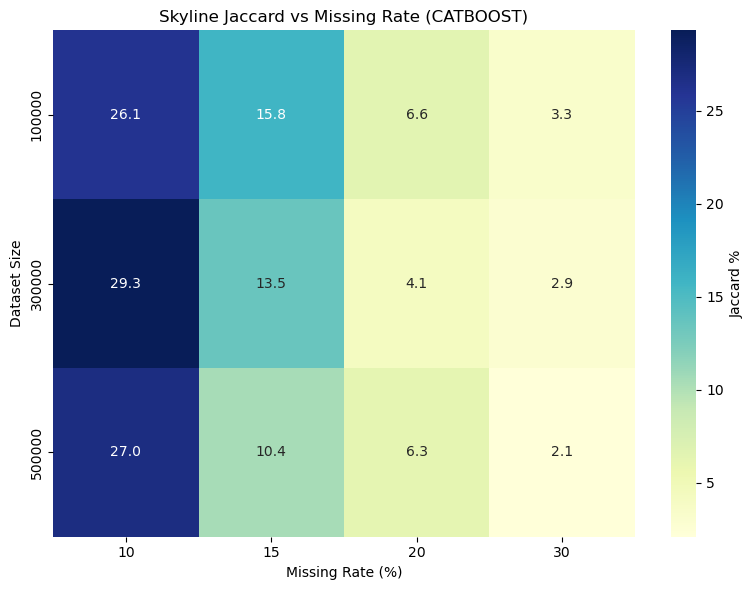

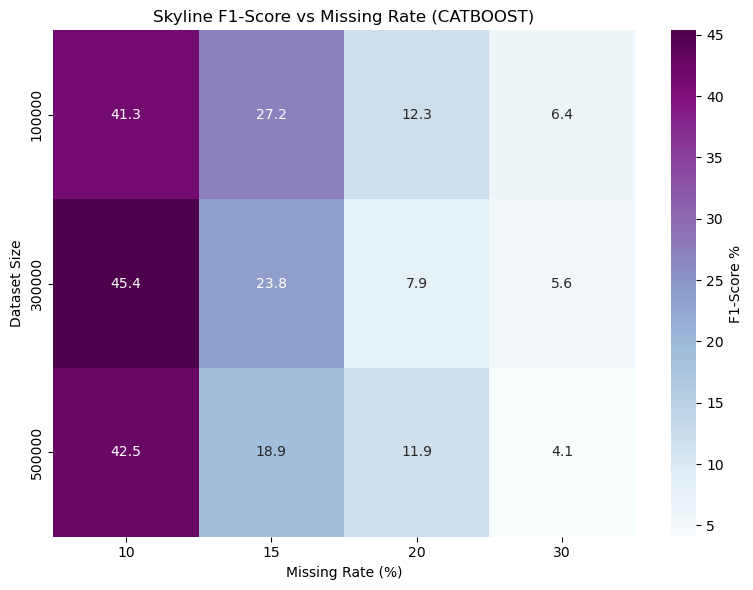

✅ Hoàn tất: đã tính Jaccard + Precision + Recall + F1 và lưu heatmap.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import os
import glob
from typing import Set

# đảm bảo SparkSession
spark = SparkSession.builder.getOrCreate()

sizes = [100000, 300000, 500000]
missing_rates = [0.1, 0.15, 0.2, 0.3]
criteria_7d = ["ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
               "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"]

# thư mục
orig_skyline_dir = "/home/jovyan/output/original/skyline_bbs_results"
imputed_skyline_dir = "/home/jovyan/output/original/data_missing/data_imputed/skyline_bbs_imputed"
output_dir = "/home/jovyan/output/analysis_results"
os.makedirs(output_dir, exist_ok=True)

# Xóa file CSV và heatmap cũ nếu tồn tại
acc_csv = os.path.join(output_dir, "skyline_accuracy_jaccard.csv")
if os.path.exists(acc_csv):
    os.remove(acc_csv)
for img in ["skyline_jaccard_heatmap.png", "skyline_f1_heatmap.png"]:
    img_path = os.path.join(output_dir, img)
    if os.path.exists(img_path):
        os.remove(img_path)

def sparkdf_to_pointset(sdf):
    """Spark DF hoặc Pandas DF -> set of tuples"""
    if sdf is None:
        return set()
    try:
        pdf = sdf.select(criteria_7d).toPandas()
    except Exception:
        pdf = sdf[criteria_7d].copy() if isinstance(sdf, pd.DataFrame) else None
    if pdf is None:
        return set()
    pdf = pdf.fillna(value=pd.NA)
    return set(map(lambda row: tuple(row.tolist()), pdf.to_numpy()))

def find_parquet_file(dir_path, pattern_prefix):
    """Tìm file parquet theo pattern"""
    if not os.path.exists(dir_path):
        return None
    candidates = glob.glob(os.path.join(dir_path, f"*{pattern_prefix}*.parquet"))
    return candidates[0] if candidates else None

results = []

for size in sizes:
    # Load original skyline
    orig_pattern = f"skyline_bbs_{size//1000}k"
    orig_file = find_parquet_file(orig_skyline_dir, orig_pattern)
    if orig_file is None:
        continue
    try:
        orig_spark_df = spark.read.parquet(orig_file)
        sky_orig_set = sparkdf_to_pointset(orig_spark_df)
    except Exception:
        continue

    for miss_rate in missing_rates:
        miss_int = int(miss_rate * 100)
        imp_pattern = f"skyline_bbs_{size//1000}k_miss{miss_int}"
        imp_file = find_parquet_file(imputed_skyline_dir, imp_pattern)
        if imp_file is None:
            continue
        try:
            imp_spark_df = spark.read.parquet(imp_file)
            sky_imp_set = sparkdf_to_pointset(imp_spark_df)

            # --- Tính các chỉ số ---
            inter = sky_orig_set.intersection(sky_imp_set)
            union_len = len(sky_orig_set.union(sky_imp_set))

            # Jaccard
            jaccard = (len(inter) / union_len * 100) if union_len > 0 else 0.0

            # Precision, Recall
            precision = (len(inter) / len(sky_imp_set) * 100) if len(sky_imp_set) > 0 else 0.0
            recall = (len(inter) / len(sky_orig_set) * 100) if len(sky_orig_set) > 0 else 0.0

            # F1-Score
            f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

            results.append((size, miss_int, len(sky_orig_set),
                            len(sky_imp_set), len(inter),
                            jaccard, precision, recall, f1))
        except Exception:
            continue

# DataFrame kết quả
df_acc = pd.DataFrame(results, columns=["Size", "MissingRate", "OrigSkyline",
                                        "ImpSkyline", "Intersection",
                                        "Jaccard", "Precision", "Recall", "F1"])

# Pivot cho heatmap
pivot_jac = df_acc.pivot(index="Size", columns="MissingRate", values="Jaccard").sort_index() if not df_acc.empty else pd.DataFrame()
pivot_f1 = df_acc.pivot(index="Size", columns="MissingRate", values="F1").sort_index() if not df_acc.empty else pd.DataFrame()

# Lưu CSV
if not df_acc.empty:
    acc_csv = os.path.join(output_dir, "skyline_jaccard_f1.csv")
    df_acc.to_csv(acc_csv, index=False)
    print(f"💾 Đã lưu kết quả Jaccard + Precision + Recall + F1 vào: {acc_csv}")
else:
    print("⚠️ Không có dữ liệu để lưu (df_acc rỗng).")

# In kết quả
if not df_acc.empty:
    print("\n💡 Skyline Jaccard (%)")
    print(pivot_jac)
    print("\n🏁 Skyline F1-Score (%)")
    print(pivot_f1)
else:
    print("⚠️ Không có dữ liệu để hiển thị.")

# Vẽ heatmap Jaccard
if not pivot_jac.empty:
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_jac, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Jaccard %'})
    plt.title("Skyline Jaccard vs Missing Rate (CATBOOST)")
    plt.ylabel("Dataset Size")
    plt.xlabel("Missing Rate (%)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "skyline_jaccard_heatmap.png"))
    plt.show()

# Vẽ heatmap F1
if not pivot_f1.empty:
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_f1, annot=True, fmt=".1f", cmap="BuPu", cbar_kws={'label': 'F1-Score %'})
    plt.title("Skyline F1-Score vs Missing Rate (CATBOOST)")
    plt.ylabel("Dataset Size")
    plt.xlabel("Missing Rate (%)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "skyline_f1_heatmap.png"))
    plt.show()

print("✅ Hoàn tất: đã tính Jaccard + Precision + Recall + F1 và lưu heatmap.")


# **Possible Skyline trên dữ liệu missing**

In [4]:
# === Cell POSSIBLE SKYLINE (hiển thị bảng thường, không màu) ===
from pyspark.sql import SparkSession, functions as F
from pyspark.storagelevel import StorageLevel
import pandas as pd
import os, glob, time, shutil, csv

# ==== Khởi tạo Spark ====
spark = SparkSession.builder.appName("PossibleSkylineMissing").getOrCreate()
spark.conf.set("spark.sql.shuffle.partitions", "256")
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

# ==== Tham số chung ====
KEY_COL = "RowID"
criteria_7d = ["ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
               "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"]
sizes = [100000, 300000, 500000]
missing_rates = [0.1, 0.15, 0.2, 0.3]

# ==== Đường dẫn ====
orig_skyline_dir = "/home/jovyan/output/original/skyline_bbs_results"
missing_data_dir = "/home/jovyan/output/original/data_missing"
out_possible_dir = os.path.join(missing_data_dir, "skyline_possible_results")
os.makedirs(out_possible_dir, exist_ok=True)
csv_path = os.path.join(out_possible_dir, "possible_skyline_results.csv")

# 🧹 === XÓA FILE CŨ TRƯỚC KHI CHẠY ===
if os.path.exists(out_possible_dir):
    for file in glob.glob(os.path.join(out_possible_dir, "*")):
        try:
            if os.path.isfile(file):
                os.remove(file)
            elif os.path.isdir(file):
                shutil.rmtree(file)
        except Exception as e:
            print(f"⚠️ Không thể xóa {file}: {e}")
print(f"🧩 Thư mục {out_possible_dir} đã được làm sạch trước khi chạy mới.\n")

# ==== Hàm chi phối "Possible" ====
def dominates_possible(r1, r2, criteria):
    better = False
    for c in criteria:
        v1, v2 = r1[c], r2[c]
        if v1 is None or v2 is None:
            continue
        if v1 > v2:
            return False
        if v1 < v2:
            better = True
    return better

# ==== Hàm tính Possible Skyline (BBS giản lược) ====
def possible_skyline(df, criteria, num_partitions=200):
    start = time.time()
    rdd = df.select(["ID"] + criteria).rdd.repartition(num_partitions)

    def partition_sky(it):
        local = []
        for row in it:
            rowd = row.asDict()
            dominated = False
            to_remove = []
            for s in local:
                sd = s.asDict()
                if dominates_possible(sd, rowd, criteria):
                    dominated = True
                    break
                if dominates_possible(rowd, sd, criteria):
                    to_remove.append(s)
            if not dominated:
                for r in to_remove:
                    local.remove(r)
                local.append(row)
        return local

    partial = rdd.mapPartitions(partition_sky).collect()
    final = []
    for row in partial:
        rowd = row.asDict()
        dominated = False
        to_remove = []
        for s in final:
            sd = s.asDict()
            if dominates_possible(sd, rowd, criteria):
                dominated = True
                break
            if dominates_possible(rowd, sd, criteria):
                to_remove.append(s)
        if not dominated:
            for r in to_remove:
                final.remove(r)
            final.append(row)

    skyline_ids = [r["ID"] for r in final]
    elapsed = time.time() - start
    print(f"✅ POSSIBLE Skyline xong ({len(skyline_ids)} điểm), thời gian {elapsed:.2f}s")
    sky_df = spark.createDataFrame([(i,) for i in skyline_ids], ["ID"]).join(df, "ID")
    return sky_df, elapsed

# ==== Hàm tìm file parquet ====
def find_parquet(dir_path, pattern):
    files = glob.glob(os.path.join(dir_path, f"*{pattern}*.parquet"))
    return files[0] if files else None

# ==== Thực thi POSSIBLE SKYLINE + tính Jaccard & F1 ====
results_possible = []
for size in sizes:
    orig_file = find_parquet(orig_skyline_dir, f"skyline_bbs_{size//1000}k")
    if not orig_file:
        continue
    orig_df = spark.read.parquet(orig_file)
    orig_set = set(tuple(x) for x in orig_df.select(criteria_7d).toPandas().to_numpy())

    for miss in missing_rates:
        miss_int = int(miss * 100)
        miss_file = find_parquet(missing_data_dir, f"data_{size//1000}k_miss{miss_int}")
        if not miss_file:
            continue
        print(f"\n🚀 POSSIBLE Skyline cho {size:,} dòng, tỷ lệ thiếu {miss_int}% ...")
        df_missing = spark.read.parquet(miss_file)

        # Ép kiểu numeric
        for c in criteria_7d:
            df_missing = df_missing.withColumn(c, F.col(c).cast("double"))

        # ==== Hiển thị tổng số dòng và 10 dòng đầu ====
        total_cnt = df_missing.count()
        print(f"👉 Tổng dòng dữ liệu missing: {total_cnt}")
        df_missing.select("ID", *criteria_7d).show(10, truncate=False)

        sky_df, t = possible_skyline(df_missing, criteria_7d)
        out_path = os.path.join(out_possible_dir, f"possible_skyline_{size//1000}k_miss{miss_int}.parquet")
        sky_df.write.mode("overwrite").parquet(out_path)

        # --- So sánh với Skyline đầy đủ ---
        poss_set = set(tuple(x) for x in sky_df.select(criteria_7d).toPandas().to_numpy())
        inter = orig_set.intersection(poss_set)
        union_len = len(orig_set.union(poss_set))
        jaccard = (len(inter) / union_len * 100) if union_len else 0
        precision = (len(inter) / len(poss_set) * 100) if len(poss_set) else 0
        recall = (len(inter) / len(orig_set) * 100) if len(orig_set) else 0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0

        results_possible.append((size, miss_int, len(orig_set), len(poss_set), len(inter),
                                 jaccard, precision, recall, f1, t))
        print(f"📊 Jaccard={jaccard:.2f}% | F1={f1:.2f}% | |Sky|={len(poss_set)}")

# ==== Lưu kết quả tổng hợp + hiển thị bảng ====  
df_res = pd.DataFrame(results_possible,
                      columns=["Kích thước", "Tỷ lệ thiếu (%)", "Skyline đầy đủ", 
                               "Skyline POSSIBLE", "Giao nhau", 
                               "Jaccard (%)", "Precision (%)", "Recall (%)", "F1 (%)", "Thời gian (s)"])
csv_path = os.path.join(out_possible_dir, "possible_skyline_results.csv")
df_res.to_csv(csv_path, index=False)
print(f"\n💾 Đã lưu kết quả tổng hợp vào: {csv_path}\n")

# Hiển thị bảng kết quả cuối cùng (bình thường, không màu)
pd.set_option('display.float_format', '{:.2f}'.format)
display(df_res)



🧩 Thư mục /home/jovyan/output/original/data_missing/skyline_possible_results đã được làm sạch trước khi chạy mới.


🚀 POSSIBLE Skyline cho 100,000 dòng, tỷ lệ thiếu 10% ...
👉 Tổng dòng dữ liệu missing: 100000
+-----+-------------+----------+------------+---------------+--------+--------+-------+
|ID   |ARRIVAL_DELAY|TAXI_TOTAL|ELAPSED_TIME|DEPARTURE_DELAY|DISTANCE|TAXI_OUT|TAXI_IN|
+-----+-------------+----------+------------+---------------+--------+--------+-------+
|57067|-5.0         |16.0      |86.0        |-1.0           |480.0   |14.0    |2.0    |
|66624|20.0         |48.0      |217.0       |3.0            |1107.0  |43.0    |5.0    |
|33967|-12.0        |NULL      |185.0       |3.0            |1381.0  |13.0    |16.0   |
|23614|-9.0         |21.0      |131.0       |-1.0           |731.0   |10.0    |11.0   |
|47469|-10.0        |22.0      |111.0       |-5.0           |645.0   |8.0     |14.0   |
|13195|-4.0         |15.0      |162.0       |9.0            |918.0   |10.0    |NULL   |

,Kích thước,Tỷ lệ thiếu (%),Skyline đầy đủ,Skyline POSSIBLE,Giao nhau,Jaccard (%),Precision (%),Recall (%),F1 (%),Thời gian (s)
0,100000,10,186,71,47,22.38,66.20,25.27,36.58,2.65
1,100000,15,186,62,33,15.35,53.23,17.74,26.61,2.92
2,100000,20,186,32,11,5.31,34.38,5.91,10.09,2.63
3,100000,30,186,50,6,2.61,12.00,3.23,5.08,2.69
4,300000,10,173,65,43,22.05,66.15,24.86,36.13,3.72
5,300000,15,173,40,19,9.79,47.50,10.98,17.84,3.54
6,300000,20,173,56,15,7.01,26.79,8.67,13.10,4.18
7,300000,30,173,74,0,0.00,0.00,0.00,0.00,3.96
8,500000,10,183,59,28,13.08,47.46,15.30,23.14,5.39
9,500000,15,183,44,17,8.10,38.64,9.29,14.98,4.64


# **Xây dựng mô hình đánh giá**

✅ Saved chart → /home/jovyan/output/original/logs/chart_bounded/overlay_f1_comparison.png


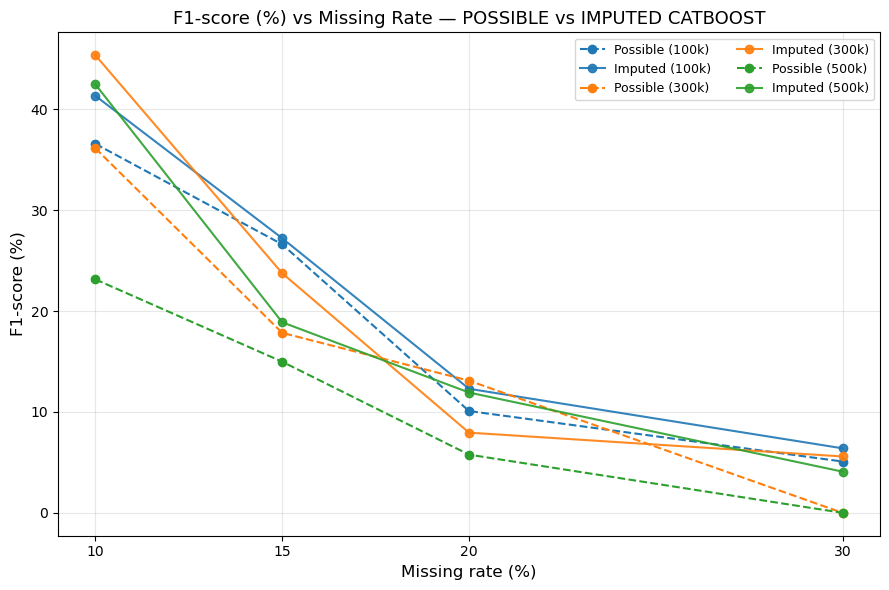

✅ Saved chart → /home/jovyan/output/original/logs/chart_bounded/overlay_jaccard_comparison.png


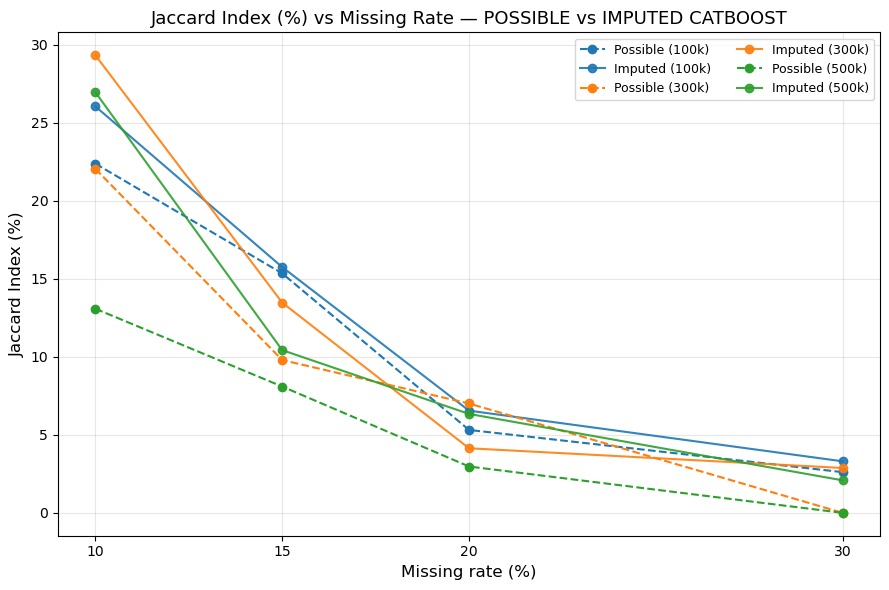


🎯 Cell 8 hoàn tất — Đã lưu biểu đồ so sánh F1 & Jaccard trong thư mục:
/home/jovyan/output/original/logs/chart_bounded


In [5]:
# ============================================================
# 📊 Cell 8 — Overlay Chart: F1 & Jaccard 
# So sánh Skyline POSSIBLE (missing) vs Skyline sau Imputed
# ============================================================
import os
import pandas as pd
import matplotlib.pyplot as plt

# ======== Đường dẫn ========
BASE_DIR = "/home/jovyan/output"
CSV_POSSIBLE = os.path.join(BASE_DIR, "original/data_missing/skyline_possible_results/possible_skyline_results.csv")
CSV_IMPUTED  = os.path.join(BASE_DIR, "analysis_results/skyline_jaccard_f1.csv")
OUT_DIR = os.path.join(BASE_DIR, "original/logs/chart_bounded")
os.makedirs(OUT_DIR, exist_ok=True)

# ======== Hàm đọc CSV & chuẩn hóa ========
def load_csv(path):
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    
    rename_map = {
        "tỷ lệ thiếu (%)": "miss_rate_pct",
        "missingrate": "miss_rate_pct",
        "missingrate(%)": "miss_rate_pct",
        "missing_rate": "miss_rate_pct",
        "missing_rate(%)": "miss_rate_pct",
        "missingratepct": "miss_rate_pct",
        "missingrate_pct": "miss_rate_pct",
        "missingratepercent": "miss_rate_pct",
        "size": "size",
        "kích thước": "size",
        "f1 (%)": "f1_percent",
        "f1": "f1_percent",
        "f1 (%) ": "f1_percent",
        "jaccard (%)": "jaccard_percent",
        "jaccard": "jaccard_percent"
    }
    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})
    
    for c in ["miss_rate_pct", "f1_percent", "jaccard_percent"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    if "size" in df.columns:
        df["size"] = df["size"].astype(str)
        df["size"] = df["size"].replace({
            "100000": "100k",
            "300000": "300k",
            "500000": "500k"
        })
    return df

df_pos = load_csv(CSV_POSSIBLE)
df_imp = load_csv(CSV_IMPUTED)

# ======== Cấu hình chung ========
sizes = ["100k", "300k", "500k"]
rate_order = [10, 15, 20, 30]
palette = {
    "100k": "#1f77b4",  # blue
    "300k": "#ff7f0e",  # orange
    "500k": "#2ca02c",  # green
}

# ======== Hàm vẽ Overlay Chart ========
def overlay_plot(metric_col, ylabel, filename):
    plt.figure(figsize=(9,6))

    for sz in sizes:
        # Dữ liệu POSSIBLE
        p = df_pos[(df_pos["size"] == sz) & (df_pos["miss_rate_pct"].isin(rate_order))][["miss_rate_pct", metric_col]]

        # Dữ liệu IMPUTED
        rate_col = None
        for cand in ["miss_rate_pct", "missingrate", "missingrate(%)", "missing_rate", "missing_rate(%)", "missingratepct", "missingrate_pct", "missingratepercent"]:
            if cand in df_imp.columns:
                rate_col = cand
                break
        if rate_col is None:
            raise ValueError("❌ Không tìm thấy cột tỷ lệ thiếu trong CSV imputed!")

        i = df_imp[(df_imp["size"] == sz) & (df_imp[rate_col].isin(rate_order))][[rate_col, metric_col]]
        i = i.rename(columns={rate_col: "miss_rate_pct"})

        # Merge 2 tập
        mg = pd.merge(
            p.rename(columns={metric_col: "possible"}),
            i.rename(columns={metric_col: "imputed"}),
            on="miss_rate_pct",
            how="inner"
        ).sort_values("miss_rate_pct")

        if mg.empty:
            print(f"⚠️ Không có dữ liệu trùng cho {sz} ({metric_col})")
            continue

        x = mg["miss_rate_pct"].values
        y_possible = mg["possible"].values
        y_imputed = mg["imputed"].values
        c = palette[sz]

        plt.plot(x, y_possible, "o--", color=c, label=f"Possible ({sz})")
        plt.plot(x, y_imputed, "o-",  color=c, alpha=0.9, label=f"Imputed ({sz})")

    plt.xlabel("Missing rate (%)", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f"{ylabel} vs Missing Rate — POSSIBLE vs IMPUTED CATBOOST", fontsize=13)
    plt.xticks(rate_order)
    plt.grid(alpha=0.3)
    plt.legend(ncol=2, fontsize=9, loc="best")
    plt.tight_layout()

    out_path = os.path.join(OUT_DIR, filename)
    plt.savefig(out_path, dpi=200)
    print(f"✅ Saved chart → {out_path}")
    plt.show()

# ======== Sinh biểu đồ ========
overlay_plot("f1_percent", "F1-score (%)", "overlay_f1_comparison.png")
overlay_plot("jaccard_percent", "Jaccard Index (%)", "overlay_jaccard_comparison.png")

print("\n🎯 Cell 8 hoàn tất — Đã lưu biểu đồ so sánh F1 & Jaccard trong thư mục:")
print(OUT_DIR)


In [6]:
# ==============================================================
# 🧩 Cell 9 — Tổng hợp kết quả POSSIBLE Skyline + Lưu CSV + Ảnh
# ==============================================================

import os, shutil
import pandas as pd

# ==== Đường dẫn ====
BASE_DIR = "/home/jovyan/output"
CSV_POSSIBLE = os.path.join(BASE_DIR, "original/data_missing/skyline_possible_results/possible_skyline_results.csv")
OUT_DIR = os.path.join(BASE_DIR, "analysis_results/final_report")
os.makedirs(OUT_DIR, exist_ok=True)

# ==== Đọc kết quả POSSIBLE ====
df_pos = pd.read_csv(CSV_POSSIBLE)

# ==== Chuẩn hóa tên cột ====
rename_map = {
    "Kích thước": "size",
    "Tỷ lệ thiếu (%)": "miss_rate_pct",
    "Skyline đầy đủ": "n_true",
    "Skyline POSSIBLE": "n_possible",
    "Giao nhau": "n_intersection",
    "Jaccard (%)": "jaccard_percent",
    "Precision (%)": "precision_percent",
    "Recall (%)": "recall_percent",
    "F1 (%)": "f1_percent",
    "Thời gian (s)": "time_seconds"
}
df_pos = df_pos.rename(columns={k: v for k, v in rename_map.items() if k in df_pos.columns})

# ==== Thêm các cột còn thiếu (n_union) ====
df_pos["n_union"] = df_pos["n_true"] + df_pos["n_possible"] - df_pos["n_intersection"]

# ==== Thêm đường dẫn output parquet tương ứng (trùng với cell POSSIBLE SKYLINE) ====
def make_parquet_path(row):
    base = "/home/jovyan/output/original/data_missing/skyline_possible_results"
    return os.path.join(base, f"possible_skyline_{int(row['size'])//1000}k_miss{int(row['miss_rate_pct'])}.parquet")

df_pos["output_parquet"] = df_pos.apply(make_parquet_path, axis=1)

# ==== Chọn & sắp xếp cột theo mẫu ====
cols = [
    "size", "miss_rate_pct", "n_true", "n_possible", "n_intersection",
    "n_union", "precision_percent", "recall_percent",
    "f1_percent", "jaccard_percent", "time_seconds", "output_parquet"
]
df_final = df_pos[cols].sort_values(["size", "miss_rate_pct"]).reset_index(drop=True)

# ==== Lưu CSV kết quả ====
final_csv = os.path.join(OUT_DIR, "skyline_possible_final_results.csv")
df_final.to_csv(final_csv, index=False)
print(f"💾 Đã lưu kết quả hợp nhất tại: {final_csv}")

# ==== Sao chép ảnh biểu đồ từ các cell trước (nếu có) ====
chart_src_dir = os.path.join(BASE_DIR, "analysis_results")
for img_name in ["skyline_jaccard_heatmap.png", "skyline_f1_heatmap.png"]:
    src = os.path.join(chart_src_dir, img_name)
    dst = os.path.join(OUT_DIR, img_name)
    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"🖼️ Đã sao chép: {img_name}")
    else:
        print(f"⚠️ Không tìm thấy ảnh {img_name} trong {chart_src_dir}")

print("\n✅ Cell 9 hoàn tất — CSV và ảnh đã lưu trong:")
print(OUT_DIR)
df_final.head(12)


💾 Đã lưu kết quả hợp nhất tại: /home/jovyan/output/analysis_results/final_report/skyline_possible_final_results.csv
🖼️ Đã sao chép: skyline_jaccard_heatmap.png
🖼️ Đã sao chép: skyline_f1_heatmap.png

✅ Cell 9 hoàn tất — CSV và ảnh đã lưu trong:
/home/jovyan/output/analysis_results/final_report


,size,miss_rate_pct,n_true,n_possible,n_intersection,n_union,precision_percent,recall_percent,f1_percent,jaccard_percent,time_seconds,output_parquet
0,100000,10,186,71,47,210,66.20,25.27,36.58,22.38,2.65,/home/jovyan/output/original/data_missing/skyl...
1,100000,15,186,62,33,215,53.23,17.74,26.61,15.35,2.92,/home/jovyan/output/original/data_missing/skyl...
2,100000,20,186,32,11,207,34.38,5.91,10.09,5.31,2.63,/home/jovyan/output/original/data_missing/skyl...
3,100000,30,186,50,6,230,12.00,3.23,5.08,2.61,2.69,/home/jovyan/output/original/data_missing/skyl...
4,300000,10,173,65,43,195,66.15,24.86,36.13,22.05,3.72,/home/jovyan/output/original/data_missing/skyl...
5,300000,15,173,40,19,194,47.50,10.98,17.84,9.79,3.54,/home/jovyan/output/original/data_missing/skyl...
6,300000,20,173,56,15,214,26.79,8.67,13.10,7.01,4.18,/home/jovyan/output/original/data_missing/skyl...
7,300000,30,173,74,0,247,0.00,0.00,0.00,0.00,3.96,/home/jovyan/output/original/data_missing/skyl...
8,500000,10,183,59,28,214,47.46,15.30,23.14,13.08,5.39,/home/jovyan/output/original/data_missing/skyl...
9,500000,15,183,44,17,210,38.64,9.29,14.98,8.10,4.64,/home/jovyan/output/original/data_missing/skyl...


In [7]:
# ==============================================================
# 🧩 Cell 10 — Lưu CSV + Ảnh từ Cell Skyline Accuracy
# ==============================================================

import os, shutil
import pandas as pd

# ==== Đường dẫn ====
BASE_DIR = "/home/jovyan/output"
CSV_INPUT = os.path.join(BASE_DIR, "analysis_results/skyline_jaccard_f1.csv")
OUT_DIR = os.path.join(BASE_DIR, "analysis_results/final_report")
CHART_SRC_DIR = os.path.join(BASE_DIR, "analysis_results")  # heatmap đã lưu ở đây
os.makedirs(OUT_DIR, exist_ok=True)

# ==== Đọc CSV kết quả ====
df_acc = pd.read_csv(CSV_INPUT)

# ==== Thêm n_union nếu chưa có ====
df_acc["n_union"] = df_acc["OrigSkyline"] + df_acc["ImpSkyline"] - df_acc["Intersection"]

# ==== Đổi tên & sắp xếp cột theo chuẩn báo cáo ====
df_final = df_acc.rename(columns={
    "Size": "size",
    "MissingRate": "miss_rate_pct",
    "OrigSkyline": "n_true",
    "ImpSkyline": "n_possible",
    "Intersection": "n_intersection",
    "Precision": "precision_percent",
    "Recall": "recall_percent",
    "F1": "f1_percent",
    "Jaccard": "jaccard_percent"
})[["size", "miss_rate_pct", "n_true", "n_possible", "n_intersection",
    "n_union", "precision_percent", "recall_percent", "f1_percent", "jaccard_percent"]]

df_final = df_final.sort_values(["size", "miss_rate_pct"]).reset_index(drop=True)

# ==== Lưu CSV tổng hợp ====
final_csv = os.path.join(OUT_DIR, "skyline_accuracy_final_results.csv")
df_final.to_csv(final_csv, index=False)
print(f"💾 Đã lưu CSV tổng hợp tại: {final_csv}")

# ==== Sao chép ảnh heatmap Jaccard & F1 ====
for img_name in ["skyline_jaccard_heatmap.png", "skyline_f1_heatmap.png"]:
    src = os.path.join(CHART_SRC_DIR, img_name)
    dst = os.path.join(OUT_DIR, img_name)
    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"🖼️ Đã sao chép: {img_name}")
    else:
        print(f"⚠️ Không tìm thấy ảnh {img_name} trong {CHART_SRC_DIR}")

print("\n✅ Cell 10 hoàn tất — CSV và ảnh đã lưu trong:")
print(OUT_DIR)
df_final.head(12)


💾 Đã lưu CSV tổng hợp tại: /home/jovyan/output/analysis_results/final_report/skyline_accuracy_final_results.csv
🖼️ Đã sao chép: skyline_jaccard_heatmap.png
🖼️ Đã sao chép: skyline_f1_heatmap.png

✅ Cell 10 hoàn tất — CSV và ảnh đã lưu trong:
/home/jovyan/output/analysis_results/final_report


,size,miss_rate_pct,n_true,n_possible,n_intersection,n_union,precision_percent,recall_percent,f1_percent,jaccard_percent
0,100000,10,186,293,99,380,33.79,53.23,41.34,26.05
1,100000,15,186,299,66,419,22.07,35.48,27.22,15.75
2,100000,20,186,367,34,519,9.26,18.28,12.30,6.55
3,100000,30,186,377,18,545,4.77,9.68,6.39,3.30
4,300000,10,173,215,88,300,40.93,50.87,45.36,29.33
5,300000,15,173,307,57,423,18.57,32.95,23.75,13.48
6,300000,20,173,456,25,604,5.48,14.45,7.95,4.14
7,300000,30,173,507,19,661,3.75,10.98,5.59,2.87
8,500000,10,183,222,86,319,38.74,46.99,42.47,26.96
9,500000,15,183,357,51,489,14.29,27.87,18.89,10.43


In [8]:
# ==============================================================
# 📦 Cell 11 — Nén & tải xuống toàn bộ kết quả Skyline (Docker Jupyter)
# ==============================================================

import os
import shutil

# ==== Đường dẫn nguồn ====
base_dir = "/home/jovyan/output"
folders_to_zip = [
    os.path.join(base_dir, "analysis_results/final_report"),
    os.path.join(base_dir, "original/data_missing/skyline_possible_results")
]

# ==== Đường dẫn file ZIP đích ====
zip_output = os.path.join(base_dir, "skyline_all_results.zip")

# ==== Xóa ZIP cũ nếu tồn tại ====
if os.path.exists(zip_output):
    os.remove(zip_output)
    print(f"🗑️ Đã xóa file ZIP cũ: {zip_output}")

# ==== Nén toàn bộ thư mục output (bao gồm 2 folder con cần thiết) ====
shutil.make_archive(zip_output.replace(".zip", ""), "zip", base_dir)
print(f"✅ Đã tạo file ZIP tại: {zip_output}")

print("\n📂 Gồm các thư mục chính:")
for f in folders_to_zip:
    print(f"   - {f}")

# ==== Kiểm tra dung lượng ZIP ====
size_mb = os.path.getsize(zip_output) / (1024 * 1024)
print(f"\n📦 Kích thước file ZIP: {size_mb:.2f} MB")

print("\n💡 Trong Docker Jupyter, bạn có thể tải file này bằng cách:")
print(f"   !cp {zip_output} /workspace/")
print("   Hoặc tải trực tiếp qua File Browser của JupyterLab.")


🗑️ Đã xóa file ZIP cũ: /home/jovyan/output/skyline_all_results.zip
✅ Đã tạo file ZIP tại: /home/jovyan/output/skyline_all_results.zip

📂 Gồm các thư mục chính:
   - /home/jovyan/output/analysis_results/final_report
   - /home/jovyan/output/original/data_missing/skyline_possible_results

📦 Kích thước file ZIP: 188.21 MB

💡 Trong Docker Jupyter, bạn có thể tải file này bằng cách:
   !cp /home/jovyan/output/skyline_all_results.zip /workspace/
   Hoặc tải trực tiếp qua File Browser của JupyterLab.
